In [63]:
# Imports
import pandas as pd
from typing import Dict
import seaborn as sns

In [64]:
# File paths
NEW_BUILD_CSV: str = "Data/Neubauwohnungen_Zürich.csv"
TAXABLE_INCOME_CSV: str = "Data/Vermögen_Stadt_zürich.csv"
EQUIVALIZED_INCOME_CSV: str = "Data/Haushaltsäquivalenz-Einkommen.csv"

In [65]:
NEW_BUILD_COLMAP: Dict[str, str] = {
    # grouping
    "KreisLang": "district_name",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    # metrics
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "num_rental_apartment",  
}

TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "SteuerEinkommen_p50": "taxable_income_p50",  # median taxable income (per year)
}

EQUIVALIZED_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "aequEK_p50": "equivalized_income_p50",  # median equivalized income (per year)
}

In [66]:
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Rename the CSV files"""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [67]:
def aggregate_new_build_by_district(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by district and five-year period.
    Logic matches the original:
      - sums of retirees, children, living area, rooms, appartements, population, rental_appartments
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["district_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda x: (x == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [68]:
def aggregate_new_build_by_quarter(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by quarter and five-year period.
    Same metrics and logic as the district-level aggregation.
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["quarter_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [69]:
def aggregate_taxable_income_by_district(
    csv_path: str = TAXABLE_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to years >= 2015, then group by district and compute the mean of the
    annual median taxable incomes (p50). Matches the original logic exactly.
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [70]:
def aggregate_equivalized_income_by_district(
    csv_path: str = EQUIVALIZED_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to 2015 <= year < 2019, then group by district and compute the mean
    of the annual median equivalized incomes (p50). Matches original logic.
    """
    df = load_and_rename(csv_path, EQUIVALIZED_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_equivalized_income=("equivalized_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [71]:
def build_join_df(
    taxable_income_by_district: pd.DataFrame,
    new_build_by_district: pd.DataFrame,
    equivalized_income_by_district: pd.DataFrame,
) -> pd.DataFrame:
    """
    Reproduce the two-step LEFT/RIGHT merge from the original code:
      1) LEFT join taxable_income_by_district with new_build_by_district on district
      2) RIGHT join result with equivalized_income_by_district on district
    The final 'right' join ensures all districts from the taxable/new_build join
    are kept (as per original).
    """
    join_left = pd.merge(
        taxable_income_by_district,
        new_build_by_district,
        on="district_name",
        how="left",
    )

    joined = pd.merge(
        equivalized_income_by_district,
        join_left,
        on="district_name",
        how="right",
    )
    return joined


In [72]:
# New-build aggregations (district & quarter)
new_build_by_quarter = aggregate_new_build_by_quarter()
new_build_by_district = aggregate_new_build_by_district()

# Income aggregations
taxable_income_by_district = aggregate_taxable_income_by_district()
equivalized_income_by_district = aggregate_equivalized_income_by_district()

# Final join
joined_df = build_join_df(
    taxable_income_by_district=taxable_income_by_district,
    new_build_by_district=new_build_by_district,
    equivalized_income_by_district=equivalized_income_by_district,
)

# View results
(new_build_by_quarter)
(taxable_income_by_district)
(equivalized_income_by_district)
(joined_df)


,district_name,median_equivalized_income,median_taxable_income,five_year_period,num_retirees,num_children,living_area,num_rooms,num_dwellings,population_total,rental_dwellings
0,Kreis 1,65.257037,77.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kreis 10,56.927500,64.533333,2015–2019,138.0,521.0,81799.0,527.0,878.0,2051.0,120.0
2,Kreis 10,56.927500,64.533333,2020–2024,53.0,207.0,39621.0,425.0,446.0,963.0,88.0
3,Kreis 11,50.025250,52.108333,2015–2019,282.0,645.0,152628.0,1127.0,1694.0,3545.0,250.0
4,Kreis 11,50.025250,52.108333,2020–2024,309.0,989.0,193924.0,974.0,2389.0,5056.0,247.0
5,Kreis 12,39.501111,41.454167,2015–2019,402.0,1003.0,157775.0,516.0,1779.0,4327.0,154.0
6,Kreis 12,39.501111,41.454167,2020–2024,216.0,197.0,45411.0,402.0,582.0,1145.0,107.0
7,Kreis 2,58.973500,64.537500,2015–2019,218.0,921.0,133098.0,714.0,1412.0,3506.0,163.0
8,Kreis 2,58.973500,64.537500,2020–2024,178.0,824.0,137466.0,645.0,1623.0,3631.0,165.0
9,Kreis 3,51.827000,54.562500,2015–2019,192.0,425.0,62254.0,499.0,740.0,1722.0,129.0


In [73]:
import pandas as pd
import numpy as np


data = pd.read_csv("Data/Wohnungen_Zürich.csv")
df_3 = data[["KreisLang", "KreisSort", "AnzZimmerLevel1Cd_noDM", "BauperiodeLevel1Lang","BauperiodeLevel1Sort","AnzWhgStat","Wohnflaeche"]].copy()

df_3 = df_3.groupby(["KreisLang", "KreisSort", "BauperiodeLevel1Lang", "BauperiodeLevel1Sort"]).aggregate({
    "AnzZimmerLevel1Cd_noDM": "sum",
    "AnzWhgStat": "sum",
    "Wohnflaeche": "sum"   
}).reset_index()

df_3 = df_3.rename(columns={
    "KreisLang": "district_name",
    "KreisSort": "district_sort",
    "BauperiodeLevel1Lang": "building_period",
    "BauperiodeLevel1Sort": "building_period_sort",
    "AnzZimmerLevel1Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "Wohnflaeche": "living_area"
})

df_3["percentage_appartments"] = (
    df_3["num_appartments"] /
    df_3.groupby("district_name")["num_appartments"].transform("sum")
)

df_3["percentage_area"] = (
    df_3["living_area"] /
    df_3.groupby("district_name")["living_area"].transform("sum")
)

df_3["area_per_appartment"] = (
    df_3["living_area"] /
    df_3["num_appartments"]
)

df_3["rooms_per_appartment"] = (
    df_3["num_rooms"] /
    df_3["num_appartments"]
)

df_3 = df_3[df_3["building_period_sort"] != 1]

df_3["rooms_per_appartment_z"] = (
    df_3["rooms_per_appartment"] - df_3["rooms_per_appartment"].mean()
) / df_3["rooms_per_appartment"].std()

df_3["area_per_appartment_z"] = (
    df_3["area_per_appartment"] - df_3["area_per_appartment"].mean()
) / df_3["area_per_appartment"].std()

df_3

,district_name,district_sort,building_period,building_period_sort,num_rooms,num_appartments,living_area,percentage_appartments,percentage_area,area_per_appartment,rooms_per_appartment,rooms_per_appartment_z,area_per_appartment_z
0,Kreis 1,1,1893 - 1899,2,1462,1740,100943,0.026366,0.021024,58.013218,0.840230,1.312916,-1.436424
1,Kreis 1,1,1900 - 1909,3,643,304,32026,0.004607,0.006670,105.348684,2.115132,4.619138,1.491542
2,Kreis 1,1,1910 - 1919,4,744,485,50663,0.007349,0.010552,104.459794,1.534021,3.112134,1.436559
3,Kreis 1,1,1920 - 1929,5,457,195,18972,0.002955,0.003951,97.292308,2.343590,5.211602,0.993209
4,Kreis 1,1,1930 - 1939,6,1324,950,84719,0.014395,0.017645,89.177895,1.393684,2.748198,0.491287
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Kreis 9,9,1980 - 1989,11,3590,34472,2797054,0.072281,0.078728,81.139882,0.104142,-0.595990,-0.005909
174,Kreis 9,9,1990 - 1999,12,3268,12004,1005519,0.025170,0.028302,83.765328,0.272243,-0.160054,0.156489
175,Kreis 9,9,2000 - 2009,13,4518,41649,4253272,0.087330,0.119716,102.121828,0.108478,-0.584747,1.291942
176,Kreis 9,9,2010 - 2019,14,4020,49832,4524132,0.104488,0.127340,90.787687,0.080671,-0.656859,0.590862


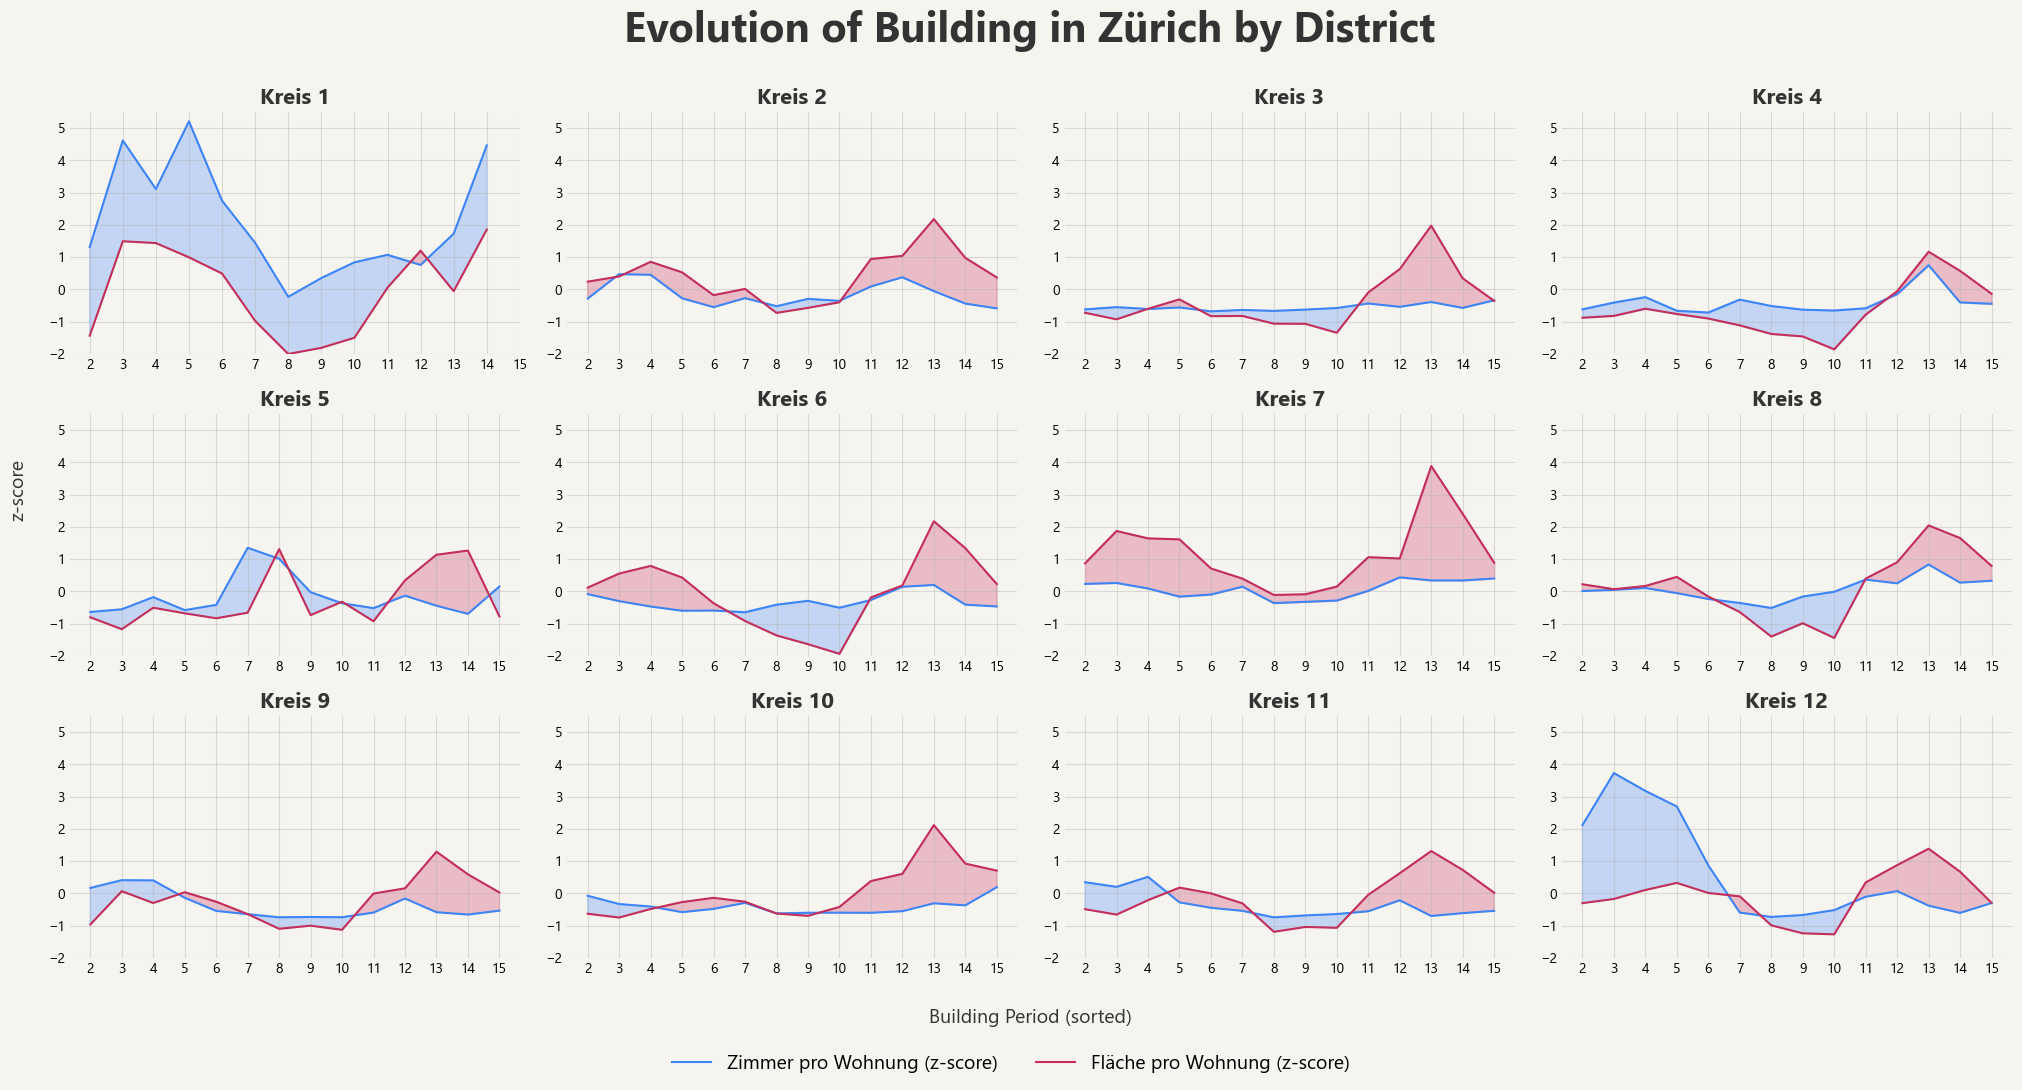

<Figure size 640x480 with 0 Axes>

In [74]:
import matplotlib.pyplot as plt
import numpy as np

BLUE = "#3D85F7"
BLUE_LIGHT = "#5490FF"
PINK = "#C32E5A"
PINK_LIGHT = "#D34068"
GREY40 = "#666666"
GREY25 = "#404040"
GREY20 = "#333333"
BACKGROUND = "#F5F4EF"

districts = (
    sorted(
        df_3["district_name"].unique(),
        key=lambda x: int(x.split()[-1])  # letzte Zahl extrahieren
    )
)

# Alle x-Werte (1,2,3,...)
x_vals = np.sort(df_3["building_period_sort"].unique())

# Mapping Sort → Jahresperiode
period_map_df = (
    df_3[["building_period_sort", "building_period"]]
    .drop_duplicates()
    .sort_values("building_period_sort")
)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0.35)   # <-- Abstand zwischen Reihen
axes = axes.flatten()

# Legendenlinien
line1 = plt.Line2D([], [], color=BLUE, label="Zimmer pro Wohnung (z-score)")
line2 = plt.Line2D([], [], color=PINK, label="Fläche pro Wohnung (z-score)")

for ax, district in zip(axes, districts):

    df = df_3[df_3["district_name"] == district]

    YEAR = df["building_period_sort"].values
    CAT = df["rooms_per_appartment_z"].values
    NOT_CAT = df["area_per_appartment_z"].values

    ax.plot(YEAR, CAT, color=BLUE)
    ax.plot(YEAR, NOT_CAT, color=PINK)

    ax.fill_between(YEAR, CAT, NOT_CAT, where=(CAT > NOT_CAT),
                    interpolate=True, color=BLUE_LIGHT, alpha=0.3)
    ax.fill_between(YEAR, CAT, NOT_CAT, where=(CAT <= NOT_CAT),
                    interpolate=True, color=PINK_LIGHT, alpha=0.3)

    # Einheitliche X-Achse
    ax.set_xticks(x_vals)

    # Einheitliche Y-Skala
    ax.set_ylim(-2, 5.5)

    # Styling
    ax.set_facecolor(BACKGROUND)
    for spine in ax.spines.values():
        spine.set_color("none")

    ax.grid(which="minor", lw=0.4, alpha=0.4)
    ax.grid(which="major", lw=0.8, alpha=0.4)
    ax.tick_params(axis="both", length=0)

    ax.set_title(district, weight="bold", color=GREY20)

fig.set_facecolor(BACKGROUND)

# Titel
fig.text(
    0.5, 0.9,
    "Evolution of Building in Zürich by District",
    ha="center", va="top",
    fontsize=30, fontweight="bold", color=GREY20
)

# Gemeinsame Y-Achse
fig.text(
    -0.01, 0.5, "z-score",
    va="center", rotation="vertical",
    fontsize=14, color=GREY20
)

# Gemeinsame X-Achse
fig.text(
    0.5, 0.06, "Building Period (sorted)",
    ha="center", va="center",
    fontsize=14, color=GREY20
)

# Legende
fig.legend(
    handles=[line1, line2],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=14
)

plt.tight_layout(rect=[0, 0.08, 1, 0.85])
plt.show()


fig.set_facecolor(BACKGROUND)

# ✔ TEXT statt Title — exakt gleiche Position wie suptitle, zentriert
fig.text(
    0.5, 0.9,
    "Evolution of Building in Zürich by District",
    ha="center", va="top",
    fontsize=30, fontweight="bold", color=GREY20
)

# Legende
fig.legend(
    handles=[line1, line2],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=14
)

# Erklärung unter der Legende

plt.tight_layout(rect=[0, 0.08, 1, 0.85])
plt.show()

fig.savefig(
    "evolution_building_zurich.png",
    dpi=1000,
    bbox_inches="tight",
)


C:\Users\livio\AppData\Local\Temp\ipykernel_22060\2968765999.py:300: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


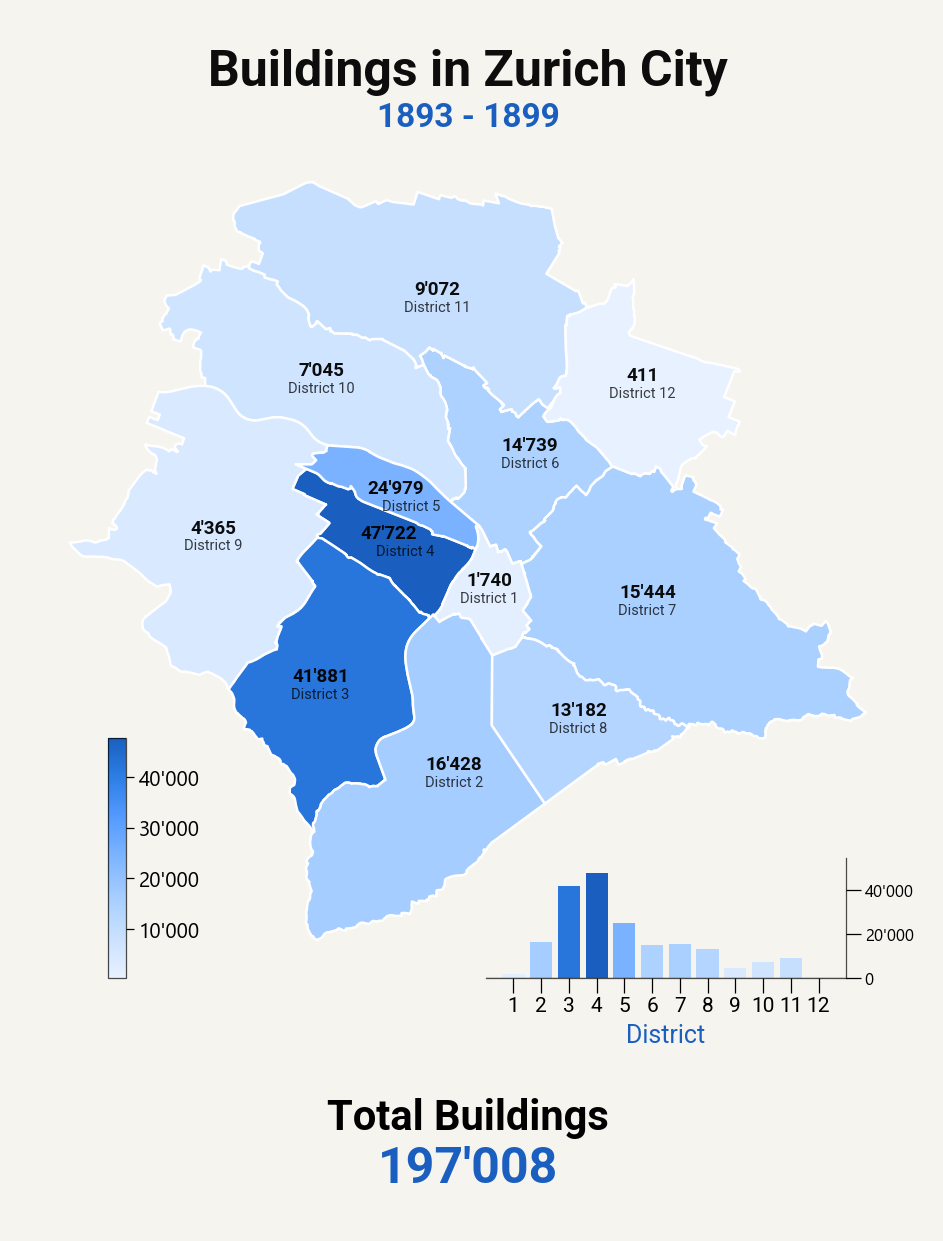

In [75]:
# ==============================
# Imports
# ==============================
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from highlight_text import fig_text

import cartopy.crs as ccrs

from pypalettes import create_cmap
from matplotlib.cm import ScalarMappable
from matplotlib import colors
import matplotlib.ticker as mticker

from pyfonts import load_google_font


# ==============================
# Consistent styling constants
# ==============================

# Figure background
BACKGROUND = "#F5F4EF"
text_color = "black"

# Projection
proj = ccrs.Mercator()

# Load fonts
regular = load_google_font("Roboto")
bold = load_google_font("Roboto", weight="bold")

# Unified Alpha Levels
ALPHA_PRIMARY = 0.95
ALPHA_SECONDARY = 0.75

# Figure text spacing
TITLE_Y = 0.95
TITLE_GAP = 0.045
SUBTITLE_Y = TITLE_Y - TITLE_GAP

# Label offsets for map polygons
LABEL_DY_VALUE = 0.0015
LABEL_DY_NAME = -0.0012

# KPI Block
KPI_X = 0.5
KPI_Y = 0.035
KPI_GAP = 0.04
KPI_LABEL_Y = KPI_Y + KPI_GAP

# Colormap
cmap = create_cmap(
    colors=[
        "#E8F1FF",
        "#C9E1FF",
        "#A7CEFF",
        "#7EB5FF",
        "#559BFF",
        "#2D7FE6",
        "#1A5FBF",
    ],
    cmap_type="continuous",
    name="BlueSoft",
)


# ==============================
# Load data
# ==============================
gdf = gpd.read_file("kreise_zuerich.geojson")

df_old = df_3[df_3["building_period_sort"] == 2][["district_name", "num_appartments", "district_sort"]]

gdf_old = gdf.merge(
    df_old,
    left_on="bezeichnung",
    right_on="district_name"
)

gdf_old["district_name"] = gdf_old["district_name"].str.replace("Kreis ", "District ")


# ==============================
# Figure & Axis
# ==============================
fig, ax = plt.subplots(
    figsize=(6, 4),
    dpi=300,
    subplot_kw={"projection": proj}
)

fig.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)
ax.set_axis_off()


# ==============================
# Title & Subtitle
# ==============================
fig_text(
    x=0.5, y=TITLE_Y,
    s="Buildings in Zurich City",
    color=text_color,
    fontsize=12,
    fontproperties=bold,
    ha="center", va="top",
    alpha=ALPHA_PRIMARY,
)

fig_text(
    x=0.5, y=SUBTITLE_Y,
    s="1893 - 1899",
    color="#1A5FBF",
    fontsize=8,
    fontproperties=bold,
    ha="center", va="top",
)


# ==============================
# Plot Map
# ==============================
gdf_old.plot(
    ax=ax,
    column="num_appartments",
    cmap=cmap,
    linewidth=0.6,
    edgecolor="#ffffff",
)


# ==============================
# Labels inside polygons
# ==============================
for _, row in gdf_old.iterrows():
    rep = row.geometry.representative_point()
    x, y = rep.x, rep.y

    name = row.get("district_name", row.get("bezeichnung"))
    num = f"{row['num_appartments']:,}".replace(",", "'")

    # Default offsets
    x_num = x
    x_name = x

    # Special case for District 4 and District 5
    if name in ["District 4", "District 5"]:
        x_num = x - 0.0015     # upper value shifted right
        x_name = x + 0.002    # lower value shifted left

    # Number (above)
    ax.text(
        x_num, y + LABEL_DY_VALUE,
        num,
        ha="center",
        va="center",
        fontproperties=bold,
        fontsize=4.5,
        color=text_color,
        alpha=ALPHA_PRIMARY,
        zorder=10,
    )

    # Name (below)
    ax.text(
        x_name, y + LABEL_DY_NAME,
        name,
        ha="center",
        va="center",
        fontproperties=regular,
        fontsize=3.5,
        color=text_color,
        alpha=ALPHA_SECONDARY,
        zorder=10,
    )


# ==============================
# Helper for number formatting
# ==============================
def thousands_formatter(x, pos):
    if x == 0:
        return "0"
    return f"{int(x):,}".replace(",", "'")


# ==============================
# KPI Block
# ==============================
total_buildings = int(gdf_old["num_appartments"].sum())
kpi_str = thousands_formatter(total_buildings, None)

fig_text(
    x=KPI_X, y=KPI_Y,
    s=kpi_str,
    color="#1A5FBF",
    fontsize=12,
    fontproperties=bold,
    ha="center", va="top",
)

fig_text(
    x=KPI_X, y=KPI_LABEL_Y,
    s="Total Buildings",
    color=text_color,
    fontsize=10,
    fontproperties=bold,
    ha="center", va="top",
)


# ==============================
# Colorbar + NEW TITLE
# ==============================
# Add colorbar axis
cax = fig.add_axes([0.3, 0.175, 0.01, 0.2])

vmin = gdf_old["num_appartments"].min()
vmax = gdf_old["num_appartments"].max()

sm = ScalarMappable(
    cmap=cmap,
    norm=colors.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="vertical",
    pad=0.02,
)

cbar.ax.tick_params(labelsize=5, width=0.3, length=2, pad=1)
cbar.outline.set_linewidth(0.3)
cbar.outline.set_alpha(0.7)
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))


# ==============================
# Small barplot at bottom
# ==============================
bar_data = gdf_old.sort_values("district_sort")

districts = bar_data["district_sort"].astype(str).values
values = bar_data["num_appartments"].values

norm = colors.Normalize(vmin=values.min(), vmax=values.max())
bar_colors = [cmap(norm(v)) for v in values]

bar_ax = fig.add_axes([0.51, 0.175, 0.2, 0.1])

bar_ax.set_facecolor("none")

bars = bar_ax.bar(
    x=range(len(values)),
    height=values,
    color=bar_colors,
)

bar_ax.set_ylim(0, max(values) * 1.15)
bar_ax.axhline(0, linewidth=0.3, color="#444444")

xtick_fp = regular.copy()
xtick_fp.set_size(5)

bar_ax.set_xticks(range(len(values)))
bar_ax.set_xticklabels(districts, fontproperties=xtick_fp)

# --- NEW: Titel für Barplot ---
bar_ax.set_xlabel(
    "District",
    fontproperties=regular,
    fontsize=6,
    labelpad=2,
    color="#1A5FBF",
)

bar_ax.tick_params(axis="x", width=0.3, pad=1)
bar_ax.yaxis.tick_right()
bar_ax.tick_params(axis="y", labelsize=4, pad=1, width=0.3)
bar_ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

for spine_name, spine in bar_ax.spines.items():
    if spine_name in ["bottom", "right"]:
        spine.set_linewidth(0.3)
        spine.set_alpha(0.7)
    else:
        spine.set_visible(False)


# ==============================
# Save
# ==============================
fig.tight_layout()

fig.savefig(
    "map.png",
    dpi=1000,
    bbox_inches="tight",
)


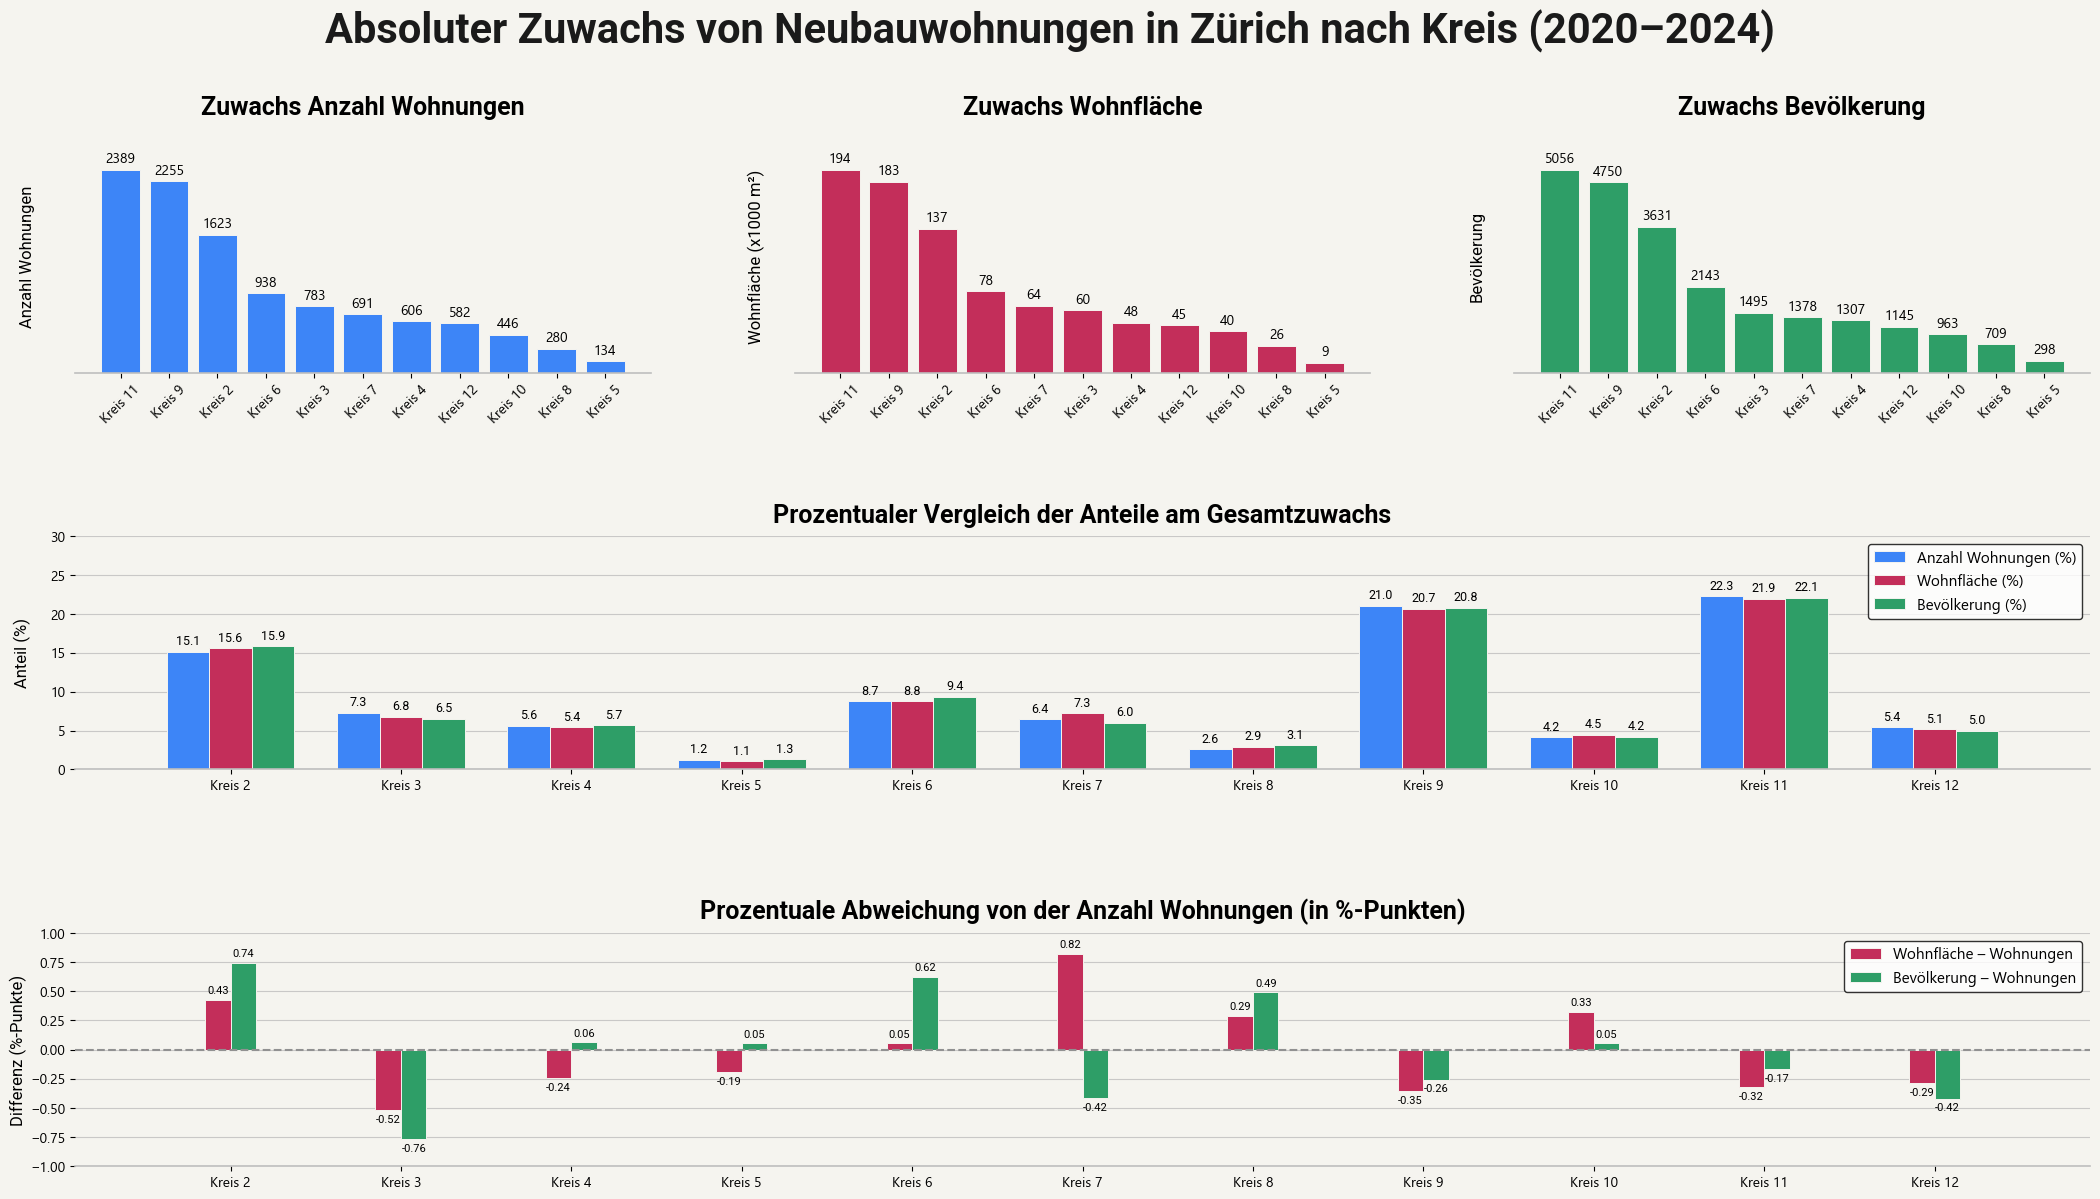

In [76]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
import pandas as pd # Import für DataFrame-Operationen

# ============================================================
# Globale Stildefinition
# ============================================================

plt.rcParams.update({
    "font.family": "Segoe UI",
    "font.size": 12,
    "axes.titlesize": 16, 
    "axes.labelsize": 13, 
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "text.color": "#000000",
    "axes.labelcolor": "#000000",
    "axes.titlecolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "legend.edgecolor": "#000000",
})

BLUE = "#3D85F7"
BLUE_LIGHT = "#5490FF"
PINK = "#C32E5A"
PINK_LIGHT = "#D34068"
GREEN = "#2E9E67"
GREEN_LIGHT = "#3FB77D"

FIGURE_BG = "#F5F4EF"      
AXES_BG = "#F5F4EF"        
GRID_COLOR = "#BEBEBE"     
EDGE_COLOR = "#F5F4EF"     

COLOR_DWELL = "#3D85F7"
COLOR_LIVING = "#C32E5A"
COLOR_POP = "#2E9E67"

# ============================================================
# Datenvorbereitung mit joined_df
# ============================================================

filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]

df = filtered[
    ["district_name", "living_area", "num_dwellings",
     "population_total", "five_year_period"]
].copy()

df["district_nr"] = df["district_name"].str.extract(r"Kreis (\d+)").astype(int)
df = df.sort_values("district_nr")

x = df["district_name"]

living_abs    = df["living_area"] / 1000 
dwellings_abs = df["num_dwellings"]
pop_abs       = df["population_total"]

# sortierte Daten
df_dwell_sorted = df.sort_values("num_dwellings", ascending=False)
x2 = df_dwell_sorted["district_name"].tolist()
dwellings_abs_sorted = np.array(df_dwell_sorted["num_dwellings"].tolist())

df_living_sorted = df.sort_values("living_area", ascending=False)
x1 = df_living_sorted["district_name"].tolist()
living_abs_sorted = np.array(df_living_sorted["living_area"].tolist()) / 1000 

df_pop_sorted = df.sort_values("population_total", ascending=False)
x3 = df_pop_sorted["district_name"].tolist()
pop_abs_sorted = np.array(df_pop_sorted["population_total"].tolist())

# ============================================================
# Figure Setup
# ============================================================
fig1 = plt.figure(figsize=(26, 13)) 
fig1.patch.set_facecolor(FIGURE_BG)

fig1.suptitle(
    "Absoluter Zuwachs von Neubauwohnungen in Zürich nach Kreis (2020–2024)",
    color="#1A1A1A",
    fontsize=30,
    fontproperties=bold,
    y=1,
)

gs = gridspec.GridSpec(3, 3, figure=fig1)

ax_abs_dwell = fig1.add_subplot(gs[0, 0])
ax_abs_living = fig1.add_subplot(gs[0, 1])
ax_abs_pop = fig1.add_subplot(gs[0, 2])

ax_pct = fig1.add_subplot(gs[1, :])      
ax_diff = fig1.add_subplot(gs[2, :], sharex=ax_pct)

# ============================================================
# Helper: Achsenformat
# ============================================================
def format_axis(ax, is_abs_plot=False):
    ax.set_facecolor(AXES_BG)

    # Grid: nur für Prozent- und Differenzplots
    if is_abs_plot:
        ax.grid(False)
    else:
        ax.grid(axis="y", alpha=0.8, color=GRID_COLOR, linewidth=0.8)

    ax.set_axisbelow(True)

    # Achsenlinien: überall nur die untere Linie sichtbar, konsistent
    for spine_name, spine in ax.spines.items():
        if spine_name == "bottom":
            spine.set_visible(True)
            spine.set_linewidth(1.2)
            spine.set_color(GRID_COLOR)
        else:
            spine.set_visible(False)

    # Y-Achse bei den absoluten Plots ohne Ticks/Labels
    if is_abs_plot:
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])

# ============================================================
# Obere Plots: Absoluter Zuwachs (Sortiert)
# ============================================================

# --- Anzahl Wohnungen ---
bars_dwell = ax_abs_dwell.bar(
    x2, dwellings_abs_sorted,
    color=COLOR_DWELL, edgecolor=EDGE_COLOR, linewidth=0.7
)
ax_abs_dwell.set_title("Zuwachs Anzahl Wohnungen", pad=18, fontproperties=bold, size=18)
ax_abs_dwell.set_ylabel("Anzahl Wohnungen", labelpad=25, fontproperties=regular)
ax_abs_dwell.bar_label(bars_dwell, padding=3, fmt="%.0f", fontsize=10)
ax_abs_dwell.tick_params(axis="x", labelrotation=45)
format_axis(ax_abs_dwell, is_abs_plot=True)
ax_abs_dwell.set_ylim(0, dwellings_abs_sorted.max() * 1.15) 

# --- Wohnfläche ---
bars_living = ax_abs_living.bar(
    x1, living_abs_sorted,
    color=COLOR_LIVING, edgecolor=EDGE_COLOR, linewidth=0.7
)
ax_abs_living.set_title("Zuwachs Wohnfläche", pad=18, fontproperties=bold, size=18)
ax_abs_living.set_ylabel("Wohnfläche (x1000 m²)", labelpad=18, fontproperties=regular)
ax_abs_living.bar_label(bars_living, padding=3, fmt="%.0f", fontsize=10)
ax_abs_living.tick_params(axis="x", labelrotation=45)
format_axis(ax_abs_living, is_abs_plot=True)
ax_abs_living.set_ylim(0, living_abs_sorted.max() * 1.15) 

# --- Bevölkerung ---
bars_pop = ax_abs_pop.bar(
    x3, pop_abs_sorted,
    color=COLOR_POP, edgecolor=EDGE_COLOR, linewidth=0.7
)
ax_abs_pop.set_title("Zuwachs Bevölkerung", pad=18, fontproperties=bold, size=18)
ax_abs_pop.set_ylabel("Bevölkerung", labelpad=18, fontproperties=regular)
ax_abs_pop.bar_label(bars_pop, padding=3, fmt="%.0f", fontsize=10)
ax_abs_pop.tick_params(axis="x", labelrotation=45)
format_axis(ax_abs_pop, is_abs_plot=True)
ax_abs_pop.set_ylim(0, pop_abs_sorted.max() * 1.15) 

# ============================================================
# Mittlerer Plot: Prozentuale Anteile
# ============================================================
y_living_pct = living_abs / living_abs.sum() * 100
y_dwell_pct  = dwellings_abs / dwellings_abs.sum() * 100
y_pop_pct    = pop_abs / pop_abs.sum() * 100

x_pos = np.arange(len(x))
bar_width_bottom = 0.25 

bars_y2 = ax_pct.bar(
    x_pos - bar_width_bottom,
    y_dwell_pct,
    bar_width_bottom,
    color=COLOR_DWELL,
    edgecolor=EDGE_COLOR,
    linewidth=0.7,
    label="Anzahl Wohnungen (%)",
)

bars_y1 = ax_pct.bar(
    x_pos,
    y_living_pct,
    bar_width_bottom,
    color=COLOR_LIVING,
    edgecolor=EDGE_COLOR,
    linewidth=0.7,
    label="Wohnfläche (%)",
)

bars_y3 = ax_pct.bar(
    x_pos + bar_width_bottom,
    y_pop_pct,
    bar_width_bottom,
    color=COLOR_POP,
    edgecolor=EDGE_COLOR,
    linewidth=0.7,
    label="Bevölkerung (%)",
)

ax_pct.set_title("Prozentualer Vergleich der Anteile am Gesamtzuwachs", pad=10, fontproperties=bold, size=18)
ax_pct.set_ylabel("Anteil (%)", labelpad=14, fontproperties=regular)
ax_pct.set_xticks(x_pos)
ax_pct.set_xticklabels(x, ha="center")

legend = ax_pct.legend(loc="upper right", frameon=True)
legend.get_frame().set_facecolor("WHITE")  # Weiss

ax_pct.bar_label(bars_y2, padding=3, fmt="%.1f", fontsize=9, fontproperties=regular)
ax_pct.bar_label(bars_y1, padding=3, fmt="%.1f", fontsize=9, fontproperties=regular)
ax_pct.bar_label(bars_y3, padding=3, fmt="%.1f", fontsize=9, fontproperties=regular)

format_axis(ax_pct)
ax_pct.set_ylim(0, 30)

# ============================================================
# Unterer Plot: Differenzen
# ============================================================
diff_living = y_living_pct - y_dwell_pct
diff_pop    = y_pop_pct    - y_dwell_pct

bar_width_diff = 0.15

bars_diff_living = ax_diff.bar(
    x_pos - bar_width_diff / 2,
    diff_living,
    bar_width_diff,
    color=COLOR_LIVING, 
    edgecolor=EDGE_COLOR,
    linewidth=0.7,
    label="Wohnfläche – Wohnungen",
)

bars_diff_pop = ax_diff.bar(
    x_pos + bar_width_diff / 2,
    diff_pop,
    bar_width_diff,
    color=COLOR_POP, 
    edgecolor=EDGE_COLOR,
    linewidth=0.7,
    label="Bevölkerung – Wohnungen",
)

ax_diff.set_title("Prozentuale Abweichung von der Anzahl Wohnungen (in %-Punkten)", pad=10, font=bold, size=18)
ax_diff.set_ylabel("Differenz (%-Punkte)", fontproperties=regular, labelpad=2)

ax_diff.set_xticks(x_pos)
ax_diff.set_xticklabels(x, ha="center")
ax_diff.set_ylim(-1, 1)
ax_diff.axhline(0, color="#919191", linewidth=1.5, linestyle='--')
    
format_axis(ax_diff)

legend_diff = ax_diff.legend(loc="upper right", frameon=True)
legend_diff.get_frame().set_facecolor("WHITE")  # Weiss

# Zahlenlabels im unteren Plot
ax_diff.bar_label(bars_diff_living, padding=3, fmt="%.2f", fontsize=8, fontproperties=regular)
ax_diff.bar_label(bars_diff_pop,    padding=3, fmt="%.2f", fontsize=8, fontproperties=regular)

# ============================================================
# Layout
# ============================================================
plt.subplots_adjust(hspace=0.7, wspace=0.25, top=0.90)

plt.savefig(
    "bars.png",
    dpi=1000,
    bbox_inches="tight",
)


c:\Users\livio\Documents\FHNW\gdv\venv_gdv\Lib\site-packages\pywaffle\waffle.py:283: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  self.set_tight_layout(self.fig_args["tight"])
C:\Users\livio\AppData\Local\Temp\ipykernel_22060\1046484225.py:90: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  fig.set_tight_layout(False)
C:\Users\livio\AppData\Local\Temp\ipykernel_22060\1046484225.py:147: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\livio\AppData\Local\Temp\ipykernel_22060\1046484225.py:147: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(

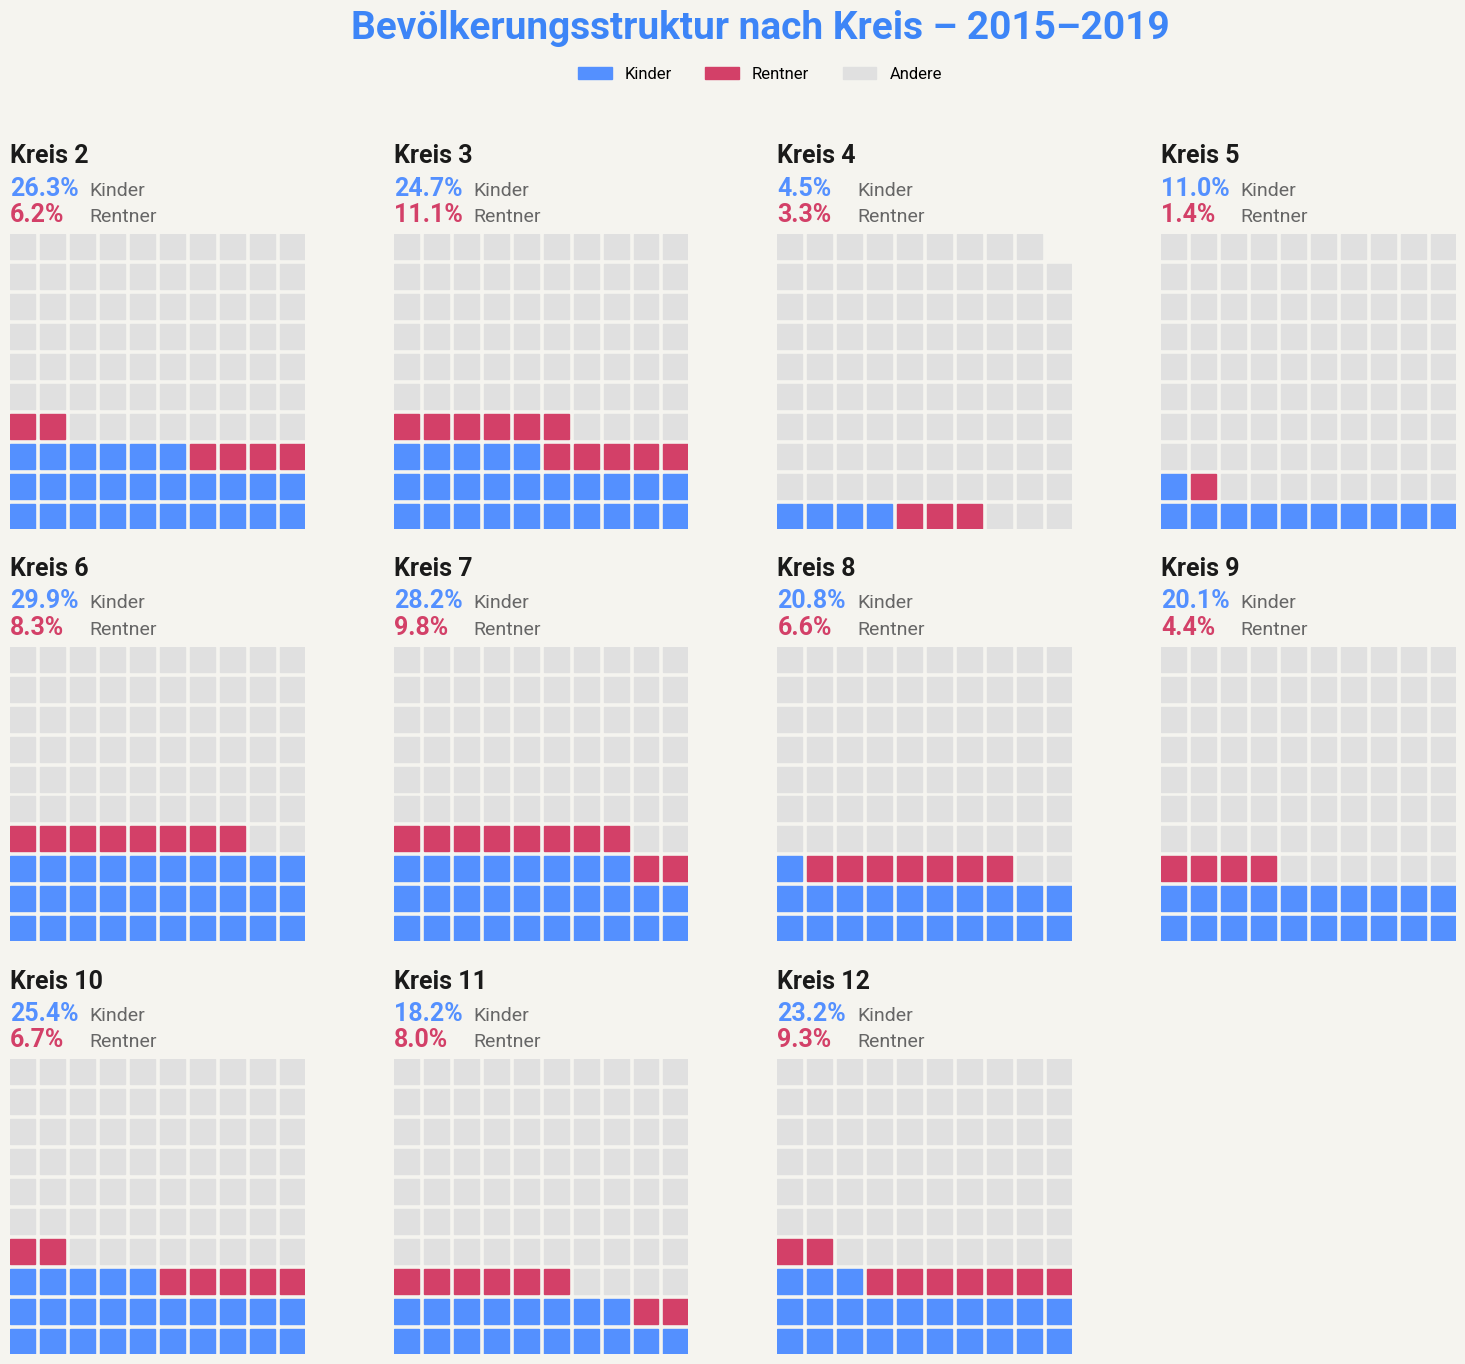

In [77]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pywaffle import Waffle

# --- 0. Deine Definitionen (Vorausgesetzt) ---
colors = [BLUE_LIGHT, PINK_LIGHT, "#E0E0E0"]
# bold = ... (FontProperties Objekt)
# regular = ... (FontProperties Objekt)
# FIGURE_BG = ...

period_of_interest = "2015–2019"

# --- 1. Daten filtern & vorbereiten ---
df_plot = (
    joined_df
    .query("five_year_period == @period_of_interest")
    .dropna(subset=["population_total"])
    .copy()
)

df_plot["num_children"] = df_plot["num_children"].fillna(0)
df_plot["num_retirees"] = df_plot["num_retirees"].fillna(0)

df_plot["other"] = (
    df_plot["population_total"]
    - df_plot["num_children"]
    - df_plot["num_retirees"]
).clip(lower=0)

# --- NEU: Kreiszahlen extrahieren und danach sortieren ---
df_plot["kreis_num"] = (
    df_plot["district_name"]
    .str.extract(r"(\d+)", expand=False)
    .astype(int)
)

df_plot = df_plot.sort_values("kreis_num")
districts = df_plot["district_name"].unique()


# --- 2. Grid und Plots initialisieren ---
n = len(districts)
ncols = 4
nrows = math.ceil(n / ncols)

plots = {}
plot_index = 1

for district in districts:
    row = df_plot[df_plot["district_name"] == district].iloc[0]
    
    val_kids = int(row["num_children"])
    val_retirees = int(row["num_retirees"])
    val_other = int(row["other"])
    
    values = {
        "Kinder": val_kids,
        "Rentner": val_retirees,
        "Andere": val_other,
    }

    # Leere Datensätze überspringen
    if sum(values.values()) == 0:
        continue

    position = (nrows, ncols, plot_index)
    
    # Wir setzen KEINEN Title im Waffle-Dict, das machen wir unten manuell
    plots[position] = {
        "values": values
    }
    plot_index += 1

# --- 3. Figure erstellen ---
fig = plt.figure(
    FigureClass=Waffle,
    plots=plots,
    rows=10, 
    columns=10, 
    colors=colors,
    vertical=True,
    starting_location='SW',
    figsize=(15, 14),  # Großes Format für Abstände
)

fig.patch.set_facecolor(FIGURE_BG)

# WICHTIG: tight_layout wieder ausschalten, sonst ignoriert Matplotlib deine Abstände
fig.set_tight_layout(False)

# --- 4. Layout Abstände (Feintuning) ---
fig.subplots_adjust(
    left=0,
    right=1,
    bottom=0.1,  # ↑ höherer Wert => Subplot-Bereich wandert nach oben
    top=0.9,
    wspace=0.1,
    hspace=0.4
)

# --- 5. Header & Legende ---

# Haupttitel (BOLD)
fig.suptitle(
    f"Bevölkerungsstruktur nach Kreis – {period_of_interest}",
    fontproperties=bold,     # <--- BOLD
    fontsize=28,
    color=BLUE,
    y=1.06
)

# Legende (REGULAR)
legend_handles = [
    Patch(color=colors[0], label="Kinder"),
    Patch(color=colors[1], label="Rentner"),
    Patch(color=colors[2], label="Andere"),
]

fig.legend(
    handles=legend_handles,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.03),
    prop=regular,            # <--- REGULAR
    fontsize=18,
)

# --- 6. Texte pro District setzen ---
for i, ax in enumerate(fig.axes):
    if i >= len(districts):
        break
        
    district_name = districts[i]
    row = df_plot[df_plot["district_name"] == district_name].iloc[0]
    
    # Prozentberechnung
    total = row["population_total"]
    if total > 0:
        pct_kids = (row["num_children"] / total) * 100
        pct_ret = (row["num_retirees"] / total) * 100
    else:
        pct_kids = 0.0; pct_ret = 0.0

    # Standard-Legende von Waffle entfernen
    ax.legend().remove()
    # --- TEXT BLOCK ---
    # Koordinaten relativ zum Plot (y > 1 ist über dem Plot)

    # A) District Titel -> BOLD
    ax.text(
        x=0.0, y=1.24, 
        s=district_name, 
        fontproperties=bold,    # <--- BOLD
        fontsize=18, 
        color="#1a1a1a", 
        ha="left", 
        transform=ax.transAxes
    )

    # B) KPI Kinder -> Zahl BOLD, Label REGULAR
    ax.text(
        x=0.0, y=1.13, 
        s=f"{pct_kids:.1f}%", 
        fontproperties=bold,    # <--- BOLD (Zahl)
        fontsize=18, 
        color=BLUE_LIGHT, 
        ha="left", 
        transform=ax.transAxes
    )
    ax.text(
        x=0.27, y=1.13, 
        s="Kinder", 
        fontproperties=regular, # <--- REGULAR (Label)
        fontsize=14, 
        color="#666666", 
        ha="left", 
        transform=ax.transAxes
    )

    # C) KPI Rentner -> Zahl BOLD, Label REGULAR
    ax.text(
        x=0.0, y=1.04, 
        s=f"{pct_ret:.1f}%", 
        fontproperties=bold,    # <--- BOLD (Zahl)
        fontsize=18, 
        color=PINK_LIGHT, 
        ha="left", 
        transform=ax.transAxes
    )
    ax.text(
        x=0.27, y=1.04, 
        s="Rentner", 
        fontproperties=regular, # <--- REGULAR (Label)
        fontsize=14, 
        color="#666666", 
        ha="left", 
        transform=ax.transAxes
    )

fig.savefig(
    "waffel.png",
    dpi=1000,
    bbox_inches="tight",
)
plt.show()

In [78]:
bevölkerung = pd.read_csv("Data/Bevölkerung.csv")
vermögen = pd.read_csv("Data/Vermögen_Stadt_Zürich.csv")

bev_ver = pd.merge(bevölkerung, vermögen, on=["StichtagDatJahr","KreisSort"], how="inner")

bev_ver = bev_ver[["StichtagDatJahr","KreisSort","KreisLang_x","AnzBestWir","SteuerTarifLang","SteuerTarifSort","SteuerEinkommen_p50","SteuerEinkommen_p25","SteuerEinkommen_p75"]]

gebäude = pd.read_csv("Data/gebäude_zürich.csv")

geb = gebäude.groupby("StichtagDatJahr")["AnzNeubauGbd_noDM"].sum().reset_index()

bev_ver_geb= pd.merge(bev_ver, geb, on="StichtagDatJahr", how="left")
bev_ver_geb

,StichtagDatJahr,KreisSort,KreisLang_x,AnzBestWir,SteuerTarifLang,SteuerTarifSort,SteuerEinkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75,AnzNeubauGbd_noDM
0,1999,1,Kreis 1,5872,Grundtarif,0,38.1,17.40,65.50,142
1,1999,1,Kreis 1,5872,Verheiratetentarif,1,83.5,52.00,131.70,142
2,1999,1,Kreis 1,5872,Einelternfamilientarif,2,48.6,26.65,87.35,142
3,1999,2,Kreis 2,28680,Grundtarif,0,38.0,20.00,58.40,142
4,1999,2,Kreis 2,28680,Verheiratetentarif,1,69.8,49.10,101.50,142
...,...,...,...,...,...,...,...,...,...,...
859,2022,11,Kreis 11,78034,Verheiratetentarif,1,82.8,53.60,124.10,248
860,2022,11,Kreis 11,78034,Einelternfamilientarif,2,49.0,28.50,77.40,248
861,2022,12,Kreis 12,32953,Grundtarif,0,35.2,15.40,54.90,248
862,2022,12,Kreis 12,32953,Verheiratetentarif,1,66.6,43.10,94.30,248


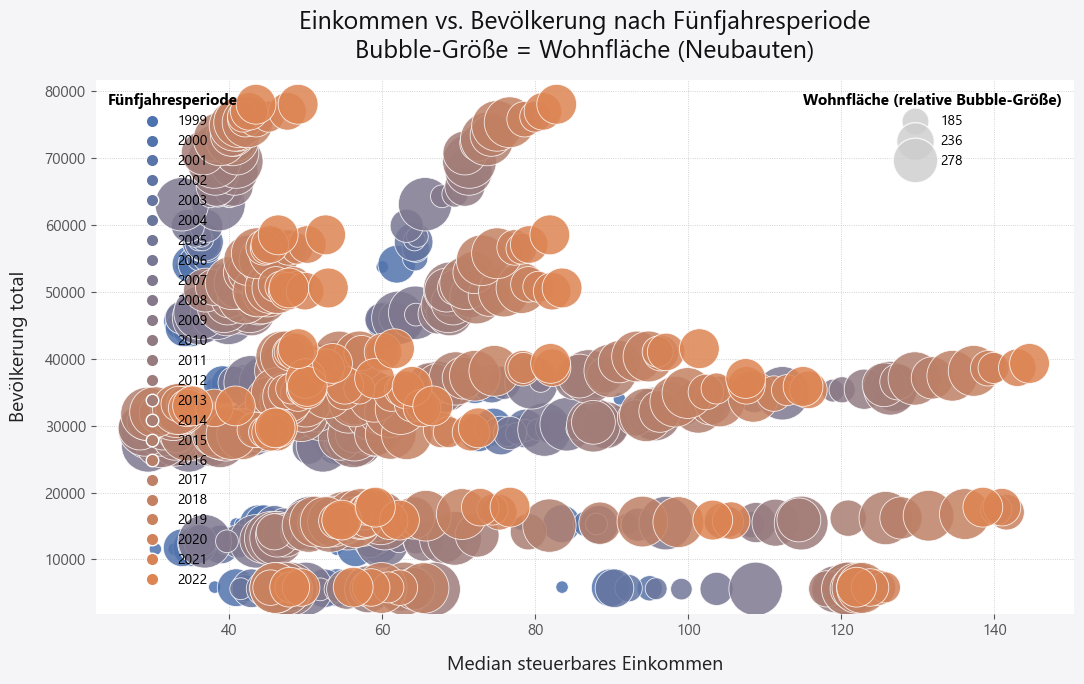

In [80]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------------------------------------
# Annahme: diese vier Variablen sind bereits definiert:
# x = ...
# y = ...
# size_raw = ...
# periods = ...
# ------------------------------------------------------------

# 1) Perioden in Codes umwandeln (für Farben)
codes, unique_periods = pd.factorize(periods)

# 2) Farbskala (weich verlaufend zwischen zwei CI-Farben)
#    Falls du CI-Farben hast: ersetze die Hex-Werte hier.
cmap = LinearSegmentedColormap.from_list(
    "periods_cmap",
    ["#4C72B0", "#DD8452"]  # z.B. blau → orange
)
norm = mpl.colors.Normalize(vmin=0, vmax=len(unique_periods) - 1)

# 3) Bubble-Größen gut skalieren
size_min, size_max = 80, 1500  # min/max Bubble-Fläche (in Punkten)

if size_raw.max() == size_raw.min():
    size_scaled = np.full_like(size_raw, (size_min + size_max) / 2, dtype=float)
else:
    size_scaled = np.interp(
        size_raw,
        (size_raw.min(), size_raw.max()),
        (size_min, size_max)
    )

# 4) Figure / Achsen-Layout
FIGURE_BG = "#f5f5f7"
AX_BG = "#ffffff"

fig, ax = plt.subplots(figsize=(11, 7))
fig.patch.set_facecolor(FIGURE_BG)
ax.set_facecolor(AX_BG)

# Achsen minimalistisch
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
ax.set_axisbelow(True)

# 5) Scatterplot
sc = ax.scatter(
    x, y,
    s=size_scaled,
    c=codes,
    cmap=cmap,
    norm=norm,
    alpha=0.85,
    edgecolor="white",
    linewidth=0.6
)

# 6) Achsen-Beschriftung, Titel
ax.set_xlabel("Median steuerbares Einkommen", fontsize=14, color="#222222", labelpad=12)
ax.set_ylabel("Bevölkerung total", fontsize=14, color="#222222", labelpad=12)

ax.set_title(
    "Einkommen vs. Bevölkerung nach Fünfjahresperiode\n"
    "Bubble-Größe = Wohnfläche (Neubauten)",
    fontsize=18,
    color="#111111",
    pad=16
)

ax.tick_params(axis="both", labelsize=11, colors="#555555")

# 7) Achsen-Ranges mit Puffer
x_margin = 0.05 * (x.max() - x.min())
y_margin = 0.05 * (y.max() - y.min())

ax.set_xlim(x.min() - x_margin, x.max() + x_margin)
ax.set_ylim(max(0, y.min() - y_margin), y.max() + y_margin)

# 8) Legende – Farben (Perioden)
color_handles = []
for i, period in enumerate(unique_periods):
    color_handles.append(
        Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markersize=9,
            markerfacecolor=cmap(norm(i)),
            markeredgecolor="white",
            label=str(period)
        )
    )

legend_colors = ax.legend(
    handles=color_handles,
    title="Fünfjahresperiode",
    loc="upper left",
    frameon=False,
    fontsize=10
)
plt.setp(legend_colors.get_title(), fontsize=11, fontweight="bold")
ax.add_artist(legend_colors)

# 9) Legende – Bubble-Größen (aus Quantilen der Größe)
quantiles = np.quantile(size_raw, [0.25, 0.5, 0.75])
sizes_for_legend = np.interp(
    quantiles,
    (size_raw.min(), size_raw.max()),
    (size_min, size_max)
)

size_handles = []
for s_leg, q in zip(sizes_for_legend, quantiles):
    size_handles.append(
        Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markersize=np.sqrt(s_leg),  # Markergröße ~ sqrt(Fläche)
            markerfacecolor="#cccccc",
            markeredgecolor="white",
            alpha=0.8,
            label=f"{q:,.0f}"
        )
    )

legend_sizes = ax.legend(
    handles=size_handles,
    title="Wohnfläche (relative Bubble-Größe)",
    loc="upper right",
    frameon=False,
    fontsize=10
)
plt.setp(legend_sizes.get_title(), fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()


c:\Users\livio\Documents\FHNW\gdv\venv_gdv\Lib\site-packages\squarify\__init__.py:231: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap()


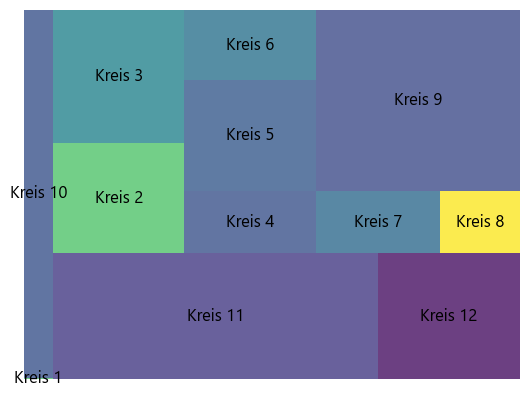

In [ ]:
# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd

# Create a data frame with fake data
df = df_3[df_3["building_period"] == "2010 - 2019"][["district_name","num_appartments"]].copy()
# plot it
squarify.plot(sizes=df['num_appartments'], label=df['district_name'], alpha=.8 )
plt.axis('off')
plt.show()
